# Face Morphing

Morphing is a technique which is widely used in motion pictures and animations to change one image or shape into another seamlessly. The idea behind Image Morphing is closely related to Face Averaging. 

<center> <img src ="https://www.learnopencv.com/wp-content/uploads/2019/10/hillary-bill.gif"/></a></center>

Given two images $I$ and $J$ we want to create an in-between image $M$ by blending images $I$ and $J$. The blending of images $I$ and $J$ is controlled by a parameter $\alpha$ that is between 0 and 1 ($0 <= \alpha <= 1$). When $\alpha$ is 0, the morph M looks like I , and when $\alpha$ is 1, M looks exactly like J. Naively, you can blend the images using the following equation at every pixel (x,y)

$$
M(x,y) = ( 1 − \alpha) I(x,y) + \alpha J(x,y)
$$

However, using the above equation to generate a blend between the image of former Secretary Hillary Clinton and Senator Ted Cruz with $\alpha$ set to 0.5, you will get the following terrible results.

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-faceMorph.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-faceMorph.png"/></a></center>

&nbsp;
**Note:** In this case the images are of the same size and so we can combine them. In general, images are of different sizes. We will handle that case in the next section. 

The resulting image is disturbing, but it also screams a solution at you. It begs you to somehow align the eyes and the mouth before blending the images.  So, to morph image $I$ into image $J$ we need to first establish pixel correspondence between the two images. In other words, for every pixel $(x_i,y_i)$in image $I$, we need to find its corresponding pixel $(x_j,y_j)$ in image $J$. Suppose we have magically found these correspondences, we can blend the images in two steps. First, we need to calculate the location $(x_m,y_m)$ of the pixel in the morphed image. It is given by the following equation

$$ 
x_m = ( 1 − \alpha )x_i + \alpha x_j
$$
$$
y_m = ( 1 − \alpha )y_i + \alpha y_j 
$$  

Second, we need to find the intensity of the pixel at $(x_m , y_m)$ using the following equation
$$
M( x_m, y_m ) = (1 − \alpha) I (x_i, y_i) + \alpha J( x_j, y_j)
$$ 

**Note:** In Face Morphing, the blending parameter $\alpha$ controls both the shape and intensity at the output pixels. 

The above equations have not solved our problem as we still need to find the corresponding pixels between $I$ and $J$. It is very difficult to do so for every point but a few point correspondences can be found easily. For morphing two dissimilar objects, like a cat’s face and a human’s face, we can click on a few points on the two images to establish correspondences and interpolate the results for the rest of the pixels. We will next see how Face Morphing is done in detail, but the same technique can be applied to any two objects.

# Face Morphing step by step

Morphing two faces can be done using the following steps. 

## Step 1 : Find Point Correspondences using Facial Landmark Detection

As you might have guessed, we start by find facial landmarks using Dlib’s landmark detector. We have chosen images of former US Secretary of State Hillary Clinton and former US President Bill Clinton because the images are of very different sizes.

<table>
    <tr>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-facialLandmarkDetection1.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-facialLandmarkDetection1.png" width=600/></a></center></th>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-facialLandmarkDetection2.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-facialLandmarkDetection2.png" width=500/></a></center></th>
    </tr>
    <tr>
    <td colspan="2"><center>Step 1: Facial Landmark Detection</center></td>
    </tr> 
</table>

## tep 2 : Coordinate Transformation

The input facial images can be of very different sizes. So we need a way to normalize the faces and bring them to the same reference frame.  To achieve this we warp the faces to a 600×600 image such that the left corner of the left eye is at pixel location ( 180, 200 ) and the right corner of the right eye is at pixel location ( 420, 200 ). Let us call this coordinate system the **output coordinate system** and the coordinates of the original images the **input coordinate systems**.

<table>
    <tr>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-facialLandmarkDetection1.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-facialLandmarkDetection1.png" width=500/></a></center></th>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-transformed.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-transformed.png" width=500/></a></center></th>
        <th><center> <a href="https://www.dropbox.com/s/cfxbhkorbrv3giu/bill-clinton-600.png?dl=1"><img src = "https://www.dropbox.com/s/cfxbhkorbrv3giu/bill-clinton-600.png?dl=1" width=500/></a></center></th>
    </tr>
    <tr>
    <td colspan="3"><center>Step 1: Step 2: The original images have been transformed to the output coordinate system. Notice, the corners of the eyes are aligned by design. However, the rest of the image is not as can be seen in the middle image which is a 50% blend of the two images. The landmark points are also transformed to the new coordinates and are displayed on the images.</center></td>
    </tr> 
</table>

**Note:** This is the same coordinate transformation we had used in Face Averaging. For more details check Face Averaging.

## Step 3 : Delaunay Triangulation

In addition to the 68 points, we add the 8 points on the boundary of the two images. This helps blend the background as well. Next we perform a Delaunay Triangulation on these 76 points. There are two sets of points corresponding to the two images. The two sets may result in a slightly different Delaunay triangulation. 

Which set of points should you use? Pause and guess the answer before you read on. 

The natural choice is to perform triangulation on the average of the two set of points as shown in the image below. The triangulation is calculated only once and stored as list of indices.
<table>
    <tr>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-delaunypoints1.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-delaunypoints1.png"/></a></center></th>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-delaunyTriangle.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-delaunyTriangle.png"/></a></center></th>
        <th><center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-delaunyPoints2.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-delaunyPoints2.png"/></a></center></th>
    </tr>
    <tr>
    <td colspan="3"><center>The points in the output coordinate system are shown in the left and right image. Delaunay triangulation is calculated on the average of the left and right shapes.</center></td>
    </tr> 
</table>

## Step 4 : Warping images and alpha blending

**We are now in a position to intelligently blend the two images. As mentioned before, the amount of blending will be controlled by a parameter $\alpha$.** 

**Create a morph using the following steps.**

* **Find location of feature points in morphed image**: In the morphed image M, we can find the locations of all 76 points (xm , ym) using equation (1).

* **Calculate affine transforms**: So we have a set of 76 points in image 1, another set of 76 points in image 2 and a third set of 76 points in the morphed image. We also know the triangulation defined over these points. Pick a triangle in image 1 and the corresponding triangle in the morphed image and calculate the affine transform that maps the three corners of the triangle in image 1 to the three corners of the corresponding triangle in the morphed image. In OpenCV, this can be done using **getAffineTransform**. Calculate an affine transform for every pair of triangles. Finally, repeat the process of image 2 and the morphed image.

* **Warp triangles**: For each triangle in image 1, use the affine transform calculated in the previous step to transform all pixels inside the triangle to the morphed image. Repeat this for all triangles in image 1 to obtain a warped version of image 1. Similarly, obtain a warped version for image 2. See the table below. 

* **Alpha blend warped images**: In the previous step we obtained warped version of image 1 and image 2. These two images can be alpha blended using equation (2), and this is your final morphed image. In the code I have provided warping triangles and alpha blending them is combined in a single step. See table below.


|The left image shows the warped image1. The right image shows the warped image2. The middle image shows the final morphed image where the left and right warped images are blended based on alpha.|
|------|
|<center><a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-warpedalpha.25.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-warpedalpha.25.png"/></a></center> | 
| <center>alpha = 0.25
Note that even though the right image is extremely distorted, it does not affect the final morph as much because its contribution is only equal to alpha (i.e. 25%).</center>     | 
|<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-warpedalpha.5.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-warpedalpha.5.png"/></a></center>|
|<center>alpha = 0.5</center>|
|<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-warpedalpha.75-1.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-warpedalpha.75-1.png"/></a></center>|
|<center>alpha = 0.75
Note that even though the left image is extremely distorted, it does not affect the final morph as much because its contribution is only equal to ( 1 - alpha )  (i.e. 25%).</center>|

### Face Morphing Code & Tutorial

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
import faceBlendCommon as fbc
import dlib
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
# Landmark model location
PREDICTOR_PATH = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [4]:
# Read two images
im1 = cv2.imread(DATA_PATH + "images/hillary-clinton.jpg")
im2 = cv2.imread(DATA_PATH + "images/presidents/bill-clinton.jpg")

In [5]:
# Detect landmarks in both images.
points1 = fbc.getLandmarks(faceDetector, landmarkDetector, im1)
points2 = fbc.getLandmarks(faceDetector, landmarkDetector, im2)

points1 = np.array(points1)
points2 = np.array(points2)

# Convert image to floating point in the range 0 to 1
im1 = np.float32(im1)/255.0
im2 = np.float32(im2)/255.0

In [6]:
# Dimensions of output image
h = 600
w = 600

# Normalize image to output coordinates.
imNorm1, points1 = fbc.normalizeImagesAndLandmarks((h, w), 
                                                  im1, points1)
imNorm2, points2 = fbc.normalizeImagesAndLandmarks((h, w), 
                                                  im2, points2)

Calculate mean landmark points, add 8 image boundary points to the mean landmark points and calculate Delaunay Triangulation.

In [7]:
# Calculate average points. Will be used for Delaunay triangulation.
pointsAvg = (points1 + points2)/2.0

# 8 Boundary points for Delaunay Triangulation
boundaryPoints = fbc.getEightBoundaryPoints(h, w)
points1 = np.concatenate((points1, boundaryPoints), axis=0)
points2 = np.concatenate((points2, boundaryPoints), axis=0)
pointsAvg = np.concatenate((pointsAvg, boundaryPoints), axis=0)

# Calculate Delaunay triangulation.
rect = (0, 0, w, h)
dt = fbc.calculateDelaunayTriangles(rect, pointsAvg)

Show morphing results using an animation by changing morphing parameter alpha. 

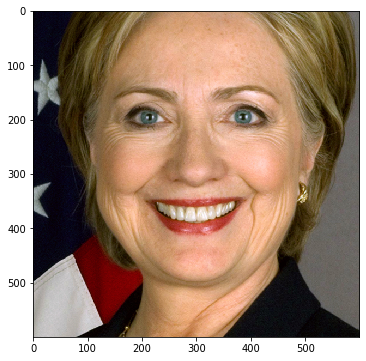

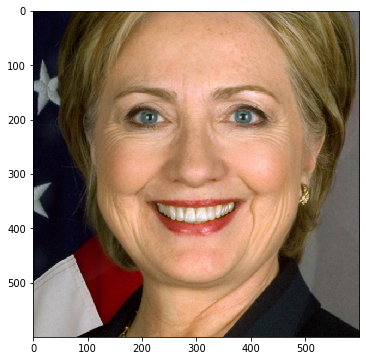

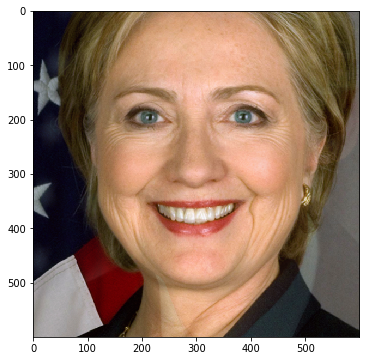

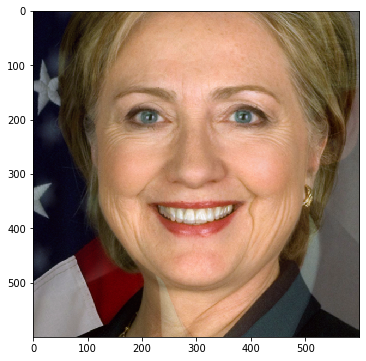

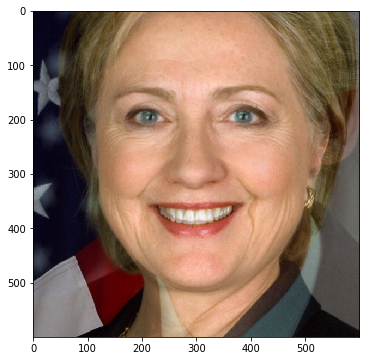

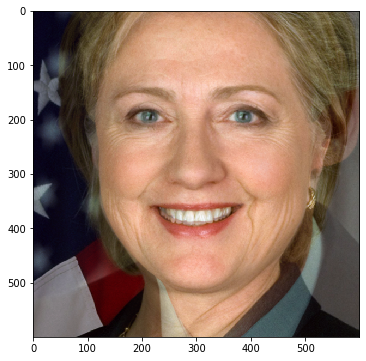

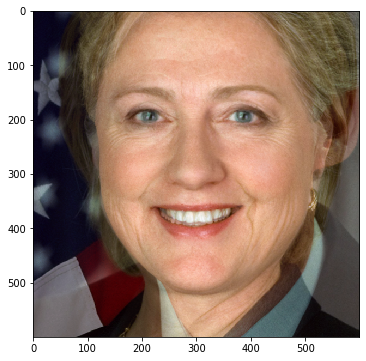

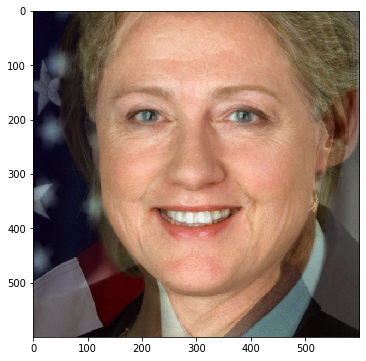

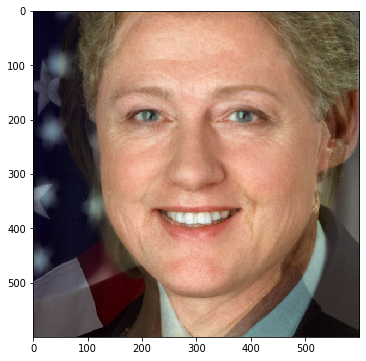

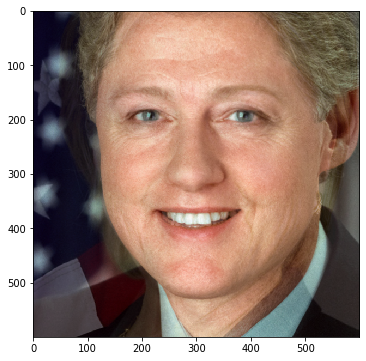

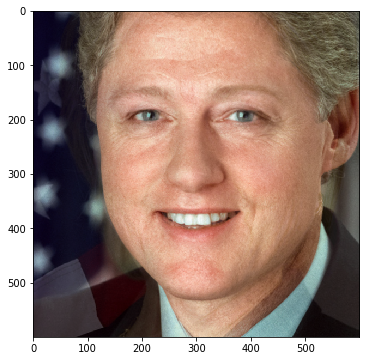

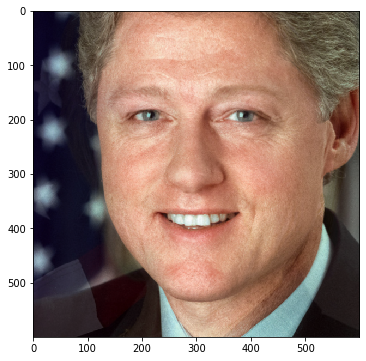

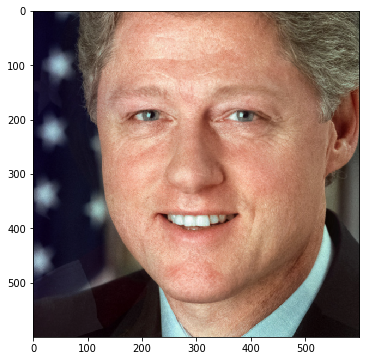

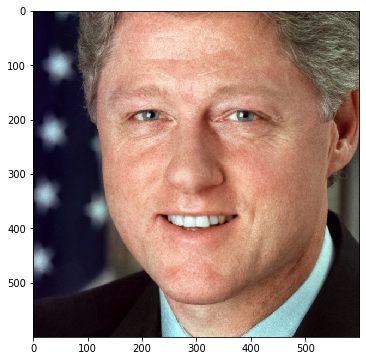

In [11]:
# Start animation.
alpha = 0
increaseAlpha = True

while True:
    # Compute landmark points based on morphing parameter alpha
    pointsMorph = (1 - alpha) * points1 + alpha * points2

    # Warp images such that normalized points line up 
    # with morphed points.
    imOut1 = fbc.warpImage(imNorm1, points1, pointsMorph.tolist(), dt)
    imOut2 = fbc.warpImage(imNorm2, points2, pointsMorph.tolist(), dt)

    # Blend warped images based on morphing parameter alpha
    imMorph = (1 - alpha) * imOut1 + alpha * imOut2
    
    # Keep animating by ensuring alpha stays between 0 and 1.
    if (alpha <= 0 and not increaseAlpha):
        increaseAlpha = True
    if (alpha >= 1 and increaseAlpha):
        break
        increaseAlpha = False

    if increaseAlpha:
        alpha += 0.075
    else:
        alpha -= 0.075

    plt.imshow(imMorph[:,:,::-1])
    plt.show()

# Face Morphing Challenges

The biggest challenge in face morphing is misaligned features. For example, in the morph below, we see ghosting artifacts on the forehead because there are no landmark points along the hairline. When completely automatic face morphing is not the goal, we can manually add additional points to make the morph look better. In the image below, we had used an additional point right above the necktie and so that point is perfectly aligned. A couple of points on the neck would have removed the ghosting artifact around the neck. 

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-faceMorphChallenge.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m5-faceMorphChallenge.png"/></a></center>

# References and Further Reading

1. [https://en.wikipedia.org/wiki/Morphing](https://en.wikipedia.org/wiki/Morphing)

2. [http://homes.cs.washington.edu/~seitz/vmorph/vmorph.htm](http://homes.cs.washington.edu/~seitz/vmorph/vmorph.htm)